In [2]:
import re

# from PyPDF2 import PdfReader
import pandas as pd
import numpy as np
# fern_species = pd.read_excel("Species list.xlsx")


In [47]:
from tqdm.auto import tqdm

conditional_newline = lambda sp: '\s*\n?'.join(sp.split(' ')).replace('.', '\.').replace('(', '\(').replace(')', '\)').replace('[', '\[').replace(']', '\]')
sp_descriptions = pd.DataFrame()
for fam in tqdm(fern_species.Family.unique()):
    text = ""
    with open(f"descriptions/{fam}.pdf", "rb") as pdf_file:
        read_pdf = PdfReader(pdf_file)
        for i, page in enumerate(read_pdf.pages):
            if i < 5:
                continue
            tx = page.extract_text()
            if tx.split("\n")[0].startswith('References'):
                # print(f"Breaking at page {i}")
                break
            text += page.extract_text()
    text = re.sub(r'[^\S\r\n]+', ' ', text)

    fam_species = fern_species[fern_species.Family.eq(fam)].Species.unique()
    sp_dict = {}
    for i, species in enumerate(fam_species):
        species = species
        if (cnt := len(re.findall(conditional_newline(species), text))) == 0:
            print(f"{fam} | {species} wrongly appearing (count: {cnt})")
            foo
        # start = text.find(species)
        # start is the first character of the species name assuming to find it in the text
        # with potentially some '\n' characters in between
        start = re.search(conditional_newline(species), text).start()
        end = [re.search(conditional_newline(sp), text).start() for sp in fam_species]
        end = min([e for e in end if e and e > start] + [len(text)])
        name_sp = species.split(')')[0] + ')'
        if name_sp not in sp_dict.keys():
            sp_dict[name_sp] = text[start:end]
        else:
            sp_dict[name_sp] += '\n' + text[start:end]

    sp_descriptions = pd.concat([sp_descriptions, pd.DataFrame(sp_dict.items(), columns=['Species', 'Description']).assign(Family=fam)], ignore_index=True)


def desc_to_sections(desc):
    """
    Split the description into sections:
    "Etymology", "Vernacular name", "Distribution", "Altitudinal range", "Biostatus", "Habitat", "First record ", "Recognition ", "Cytology", "Hybridisation", "Notes "
    not all the sections will be present in all descriptions, if present, they start with the section name followed by a colon, up to the next named section or the end of the description
    """
    sections = ["Etymology", "Vernacular name", "Distribution", "Altitudinal range", "Biostatus", "Habitat", "First record", "Recognition", "Cytology", "Hybridisation", "Notes"]
    section_dict = {}
    for i, section in enumerate(sections):
        if i == len(sections) - 1:
            section_dict[section] = desc
        else:
            start = re.search(fr"{section}s?:", desc)
            start = start.end() if start else -1
            if start == -1:
                continue
            end = re.search(fr"{sections[i+1]}s?:", desc)
            end = end.start() if end else -1

            this_desc = desc[start:end].strip()

            section_dict[section] = re.sub(r'\n+', ' ', this_desc.strip())
    return pd.Series(section_dict)

extra = sp_descriptions.Description.apply(desc_to_sections)  
sp_descriptions = pd.concat([sp_descriptions, extra], axis=1).drop(columns='Description')

  0%|          | 0/32 [00:00<?, ?it/s]

In [50]:
sp_descriptions.to_excel("fern_descriptions.xlsx", index=False)

# Extract features

In [3]:
sp_descriptions = pd.read_excel("fern_descriptions.xlsx").set_index('Species')

In [34]:
extra_features_df = pd.read_excel("../Words before and after traits_v2.xlsx", sheet_name="FernPrecedingWords")
extra_features_df = extra_features_df.drop(columns=[c for c in extra_features_df.columns if 'Unnamed' in c])
extra_features_df = extra_features_df[
    :extra_features_df[extra_features_df.Rhizome.str.startswith('Sentences that talk a', na=False)].index[0]
    ].map(lambda s:s.lower().strip() if type(s) == str else s)

extra_features = extra_features_df.to_dict('list')
extra_features = {k.title().replace(' ', ''): [x for x in v if str(x) != 'nan'] for k, v in extra_features.items()}

In [35]:
extra_features

{'Rhizome': ['rhizome', 'rhizomes', 'stem', 'stems'],
 'Frond': ['fronds', 'frond', 'leaf', 'leaves'],
 'FertileFronds': ['fertile'],
 'SterileFronds': ['sterile'],
 'Stipe': ['stipe', 'stipes'],
 'Rachis': ['rachis', 'rachises'],
 'Laminae': ['laminae', 'lamina'],
 'Sori': ['sori', 'sorus'],
 'Spores': ['spores', 'spore'],
 'Sporangia': ['sporangia', 'sporangium', 'synangia', 'synangium'],
 'Habitat**': ['aquatic',
  'epiphytic',
  'creeping',
  'climbing',
  'climber',
  'climbers',
  'creeper',
  'creepers',
  'terrestrial',
  'lithophytic'],
 'Indusia': ['indusia', 'indusium'],
 'Habit': ['creeping, terrestrial, both'],
 'Biostatus': ['indigenous',
  'native',
  'exotic',
  'endemic',
  'non-endemic',
  'casual',
  'fully naturalized']}

In [45]:
# sp_descriptions[sp_descriptions['Biostatus'].str.replace('Non-endemic', '').apply(lambda s: 'exotic' in s.lower())].Biostatus
# set(sum(sp_descriptions['Biostatus'].str.replace('.', '').str.split(')').str[0].str.split('; ').to_list(), []))

Biostatus
[indigenous]                 113
[indigenous, endemic]         93
[exotic, casual]              37
[exotic]                      26
[indigenous, non-endemic]      1
Name: count, dtype: int64

In [5]:
unit = '[m|c|d|μ]?m'
number = r"(\d+\.?\d*)"
full_regex = rf"(({number}\s?-\s?)?{number})?({number}\s?-\s?)?{number}\s*{unit}(-wide)?(-long)?"

In [6]:
tmp = []
anomalies = set() # species with anomalies

def extract_features(i, feats:list):
	features = {}
	for feat in feats:
		if len(feat) < 1:
			continue
		feat = feat.replace(',', ' ')
		measures = re.finditer(full_regex, feat)
		for measure in measures:
			found = None
			for key, values in extra_features.items():
				if key in ('Habit', 'Venation', 'Biostatus'):
					continue

				feat = feat[:-1] if feat[-1] in ['.', ';'] else feat # remove any of .; at the end of the sentence
				matched_word = list(re.finditer( r'\b('+ '|'.join([w for w in set(values)]) + r')\b', feat.lower()))
				
				if any(matched_word):
				# "*Secondary* pinnae decreasing very gradually in length along each ~primary~ pinna to the distal end..." is supposed to be Secondary
					if key == 'Laminae' and 'primary' in feat.lower() and len(features.get('Laminae', [])) >= 2:
						continue
					if key == 'PrimaryPinnae' and 'secondary' in feat.lower() and len(features.get('PrimaryPinnae', [])) >= 2:
						continue
					matched_word = [w for w in matched_word if w.span()[0] < measure.span()[0]]
					if not any(matched_word):
						continue
					matched_word = sorted(matched_word, key=lambda word: word.span()[1] - measure.span()[0])[0]
					this_distance = abs(matched_word.span()[1] - measure.span()[0])
					# this_distance = abs(word_match_position - measure_position)

					if key in ['Stipe', 'Laminae', 'Rhizome']:
						hair_or_scale_position = list(re.finditer(r'(hair|scale)', feat.lower()))
						# C1: Se nella frase dello stipe trovi le keyword "hair", "hairs", "scale", "scales", i valori dopo queste keyword vanno ignorati.
						if any(hair_or_scale_position) and hair_or_scale_position[0].start() < measure.start():
							continue
					if found:
						if this_distance >= found[1]:
							continue
						features[found[0]].remove(found[2])
						anomalies.add(i)

					found = (key, this_distance, measure.group())
					if key in features:
						features[key].append(measure.group())
					else:
						features[key] = [measure.group()]
	return pd.Series(features)



In [6]:
def string_preprocessing(s):
	s = s.replace('\xa0', ' ').replace('×', 'x').replace('–', '-').replace('·', '.') # remove non-breaking space and replace multiplication sign with x
	s = re.sub(r'(?<=xcluding)\s+[\w-]+', ' ', s) # remove each word following "excluding" (Mericarps (excluding style) 2.5-3.0 mm should point to "Mericarps")
	s = re.sub(fr'-?\(-?{number}-?\)-?', '', s) # remove all parentesis surrounding a number and the number inside (e.g. (-1.5) --> **)
	# s = s.replace('--', '-').replace('-.', '-').replace('..', '.')
	# s = s.replace('(', '').replace(')', '')
	# s = re.sub(r'\s(c|ca|o)\.', ' foo ', s) # remove all ' c.'
	s = re.sub(rf'(?<=\d)\s+(?={unit})', '', s) # remove all spaces before measures (mm, cm, dm, m, these strings only if padded by a space)
	s = re.sub('m long;?', 'm-long', s) # remove space between measure and "long" (e.g. 2 mm long --> 2 mm-long)
	s = re.sub('m wide;?', 'm-wide', s) # remove space between measure and "wide" (e.g. 2 mm wide --> 2 mm-wide)
	s = re.sub(r'\s*-\s*', '-', s) # remove spaces around hyphens
	s = re.sub(r'(?<=\d)\s*\.(?=\d)', '.', s) # remove spaces before dot if followed and preceded by a number
	s = re.sub(r'(?<=\s)\.(?=\d)', '0.', s) # add a 0 before a dot if it is preceded by a space and a "not number" and followed by a number (e.g. foo .5 --> foo 0.5)
	# s = re.sub(r'(?<=[\dm])\s*x\s*(?=\d+)', 'x', s) # remove spaces around x in formulas
	s = re.sub(rf'(;\s*)({full_regex})', r' \2', s) # point to any ';' preceding a measure (full_regex) and remove it, without removing the measure
	return s

In [12]:
sp_descriptions

,Family,Etymology,Distribution,Altitudinal range,Biostatus,Habitat,First record,Recognition,Notes,Vernacular name,Cytology,Hybridisation
Species,,,,,,,,,,,,
Anemia phyllitidis (L.),Anemiaceae,From the Greek phyllitidis (like Phyllitis ). ...,North Island: Northland,10 m. Known as a cultivation escape from one l...,Exotic; casual.,"Reported as growing on a steep, south-facing b...","Ogle et al. (2021). Voucher AK 327905, 2008.","New Zealand material, comprising one known col...","Anemia phyllitidis (L.) Sw., Syn. Fil. 155 (18...",NaN,NaN,NaN
Athyrium filix-femina (L.),Athyriaceae,From the Latin filix (fern) and femina (female...,North Island: Auckland. South Island: Canterbu...,0–30 m. A widespread northern temperate specie...,Exotic; fully naturalised.,Athyrium filix-femina occurs most frequently o...,"Molloy (1976, p. 16). Voucher CHR 172587, WELT...",Athyrium filix-femina is a naturalised plant c...,"Athyrium filix-femina (L.) Roth, Tent. Fl. Ger...","lady fern Rhizomes erect, sometimes forming sh...",NaN,NaN
Athyrium otophorum (Miq.),Athyriaceae,From the Greek otos (ear) and phorus (bearing)...,North Island: Northland.,10 m. Known from one locality in Kerikeri. Occ...,Exotic; casual.,Recorded as sporadically self-sown along the e...,"Heenan et al. (2004, p. 802). Voucher AK 28399...","In New Zealand Athyrium otophorum has a short,...","Athyrium otophorum (Miq.) Koidz., Fl. Symb. Or...",NaN,The base chromosome number in Deparia is x = 4...,NaN
Deparia petersenii subsp. congrua (Brack.),Athyriaceae,From the Latin congruus (agreeable). Rhizomes ...,"North Island: Northland, Auckland, Volcanic Pl...",0–400 m. Deparia petersenii subsp. congrua occ...,Indigenous (Non-endemic).,Deparia petersenii subsp. congrua is a terrest...,NaN,In New Zealand Deparia petersenii subsp. congr...,Deparia petersenii subsp. congrua (Brack.) M.K...,NaN,n = 82 (Brownlie 1961). Notes: This species ha...,NaN
Deparia petersenii (Kunze),Athyriaceae,"From the Greek diplasios (double), a reference...",North Island: Volcanic Plateau.,10 m. Deparia petersenii subsp. petersenii is ...,Exotic; casual.,Recorded from concrete and brick walls in a ga...,"New record. Voucher AK 363422, 2016.",Very similar to subsp. congrua but distinguish...,"Deparia petersenii (Kunze) M.Kato, Bot. Mag. (...",NaN,The base chromosome number in Diplazium is x =...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
Cyclosorus interruptus (Willd.),Thelypteridaceae,From the Latin interruptus (interrupted). Rhiz...,"North Island: Northland, Auckland, Volcanic Pl...",0–600 m. Cyclosorus interruptus occurs in coas...,Indigenous (Non-endemic). The species was give...,"Occurs in swamps, on peaty soils and lake marg...",NaN,Cyclosorus interruptus is recognised by its lo...,"Cyclosorus interruptus (Willd.) H.Itô, Bot. Ma...",NaN,"n = 36 ( Brownlie 1961 , as Cyclosorus gongylo...",NaN
Macrothelypteris torresiana (Gaudich.),Thelypteridaceae,Named in honour of Luís Vaz de Torres (b. 1565...,North Island: Northland Kermadec Islands,30–120 m. In New Zealand Macrothelypteris torr...,Indigenous (Non-endemic). The species was give...,Macrothelypteris torresiana has been recorded ...,NaN,Macrothelypteris torresiana is recognised by i...,"Macrothelypteris torresiana (Gaudich.) Ching, ...",NaN,2n = 124 ( de Lange et al. 2004 ). Notes: Name...,NaN
Pakau pennigera (G.Forst.),Thelypteridaceae,From the Latin pennigerus (with feathery leave...,"North Island: Northland, Auckland, Volcanic Pl...",0–700 m. Pakau pennigera occurs in lowland are...,Indigenous (Non-endemic).,"A terrestrial fern that occurs under kauri, po...",NaN,Pakau pennigera is recognised by its erect rhi...,Pakau pennigera (G.Forst.) S.E.Fawc. & A.R.Sm....,feather fern; gully fern; piupiu; pākau; pākau...,"n = 72 ( Brownlie 1954 , as Cyclosorus pennige...",NaN


In [48]:
features = sp_descriptions.Etymology.fillna('') + ' ' + sp_descriptions['Vernacular name'].fillna('')
# delimiter any of '. ', '.\n' and similar (all the dots not followed by numbers and not preceded by ' c', enforced with a negative lookbehind)
delimiter = r'(?<! c)\.(?!\d)'
features = features.apply(string_preprocessing).str.split(delimiter).reset_index().apply(lambda x: extract_features(x.Species, x[0]), axis=1)
features = features.map(lambda x: '; '.join(x) if not isinstance(x, float) else x)
features.index = sp_descriptions.index
features = features[features.notna().sum(axis=1) > 0].join(sp_descriptions.Family).map(lambda x: x if x != '' else np.nan)

features['Biostatus'] = sp_descriptions['Biostatus'].str.replace('Non-endemic', '').apply(lambda s: [x for x in extra_features['Biostatus'] if x.lower() in s.lower() and not ('non-' in s and x=='endemic')]).value_counts()
features.to_csv('processed_features_fern.csv')

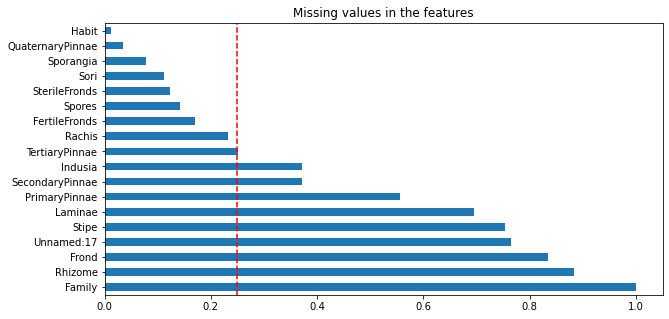

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
(features.notna().sum()/features.shape[0]).sort_values(ascending=False).plot(kind='barh', figsize=(10, 5), title='Missing values in the features')
ax.axvline(0.25, color='r', linestyle='--')

In [50]:
features[features.QuaternaryPinnae.notna() ].QuaternaryPinnae

Species
Diplazium australe (R.Br.)                                                   7mm-long; 3mm-wide
Asplenium hookerianum Colenso, Tasmanian J. Nat. Sci. 2: 169 (1845)    4mm-long; 0.3-0.5mm-wide
Davallia griffithiana Hook., Sp. Fil. 1, 168, t. 49B (1845)                 12mm-long; 5mm-wide
Hypolepis dicksonioides (Endl.)                                         7-16mm-long; 2-6mm-wide
Hypolepis millefolium Hook., Sp. Fil. 2, 68, t. 95b (1852)               1-5mm-long; 1-4mm-wide
Pteridium esculentum (G.Forst.)                                        4-25mm-long; 1-10mm-wide
Lastreopsis hispida (Sw.)                                                   13mm-long; 4mm-wide
Lastreopsis velutina (A.Rich.)                                              10mm-long; 6mm-wide
Pteris tremula R.Br., Prodr. Fl. Nov. Holland. 154 (1810)               4-20mm-long; 1-4mm-wide
Name: QuaternaryPinnae, dtype: object

In [54]:
features.map(lambda x: '-'.join([w for w in ['wide', 'long'] if w in x.lower()]) if isinstance(x, str) else np.NaN).apply(lambda x: x.unique())

FertileFronds       [long, nan, wide-long, wide, ]
Frond                     [long, nan, wide-long, ]
Habit                                      [nan, ]
Indusia                   [nan, long, wide-long, ]
Laminae             [wide-long, nan, long, wide, ]
PrimaryPinnae         [wide-long, nan, long, wide]
QuaternaryPinnae                  [nan, wide-long]
Rachis                [nan, wide-long, long, wide]
Rhizome             [nan, wide-long, , long, wide]
SecondaryPinnae             [nan, wide-long, long]
Sori                           [nan, , long, wide]
Sporangia                 [nan, long, wide-long, ]
Spores                            [nan, wide-long]
SterileFronds               [wide-long, nan, long]
Stipe               [long, , nan, wide-long, wide]
TertiaryPinnae              [nan, wide-long, long]
Unnamed:17          [, wide-long, nan, wide, long]
Family                                          []
dtype: object

In [59]:
filt_features = features[features.columns[features.notna().sum()/features.shape[0] > 0.25]]

In [72]:
import numpy as np
import pint
ureg = pint.UnitRegistry()

def range_to_num(s):
	if s.lower() in ['', 'nan']:
		return np.NaN
	metric = next(re.finditer(unit, s))
	value = s[:metric.start()]
	if '-' in value:
		value = np.array(value.split('-')).astype(float).mean()
	else:
		value = float(value)
	return ureg.Quantity(value, metric.group()).to('mm').magnitude


s = '115-510mm-long; 40-270mm-wide;...'
def processFeat(s:str, words=('wide', 'long')):
	if s.lower() in ['', 'nan']:
		return pd.Series({w: np.NaN for w in words})
	
	slist = s.split(';')
	m = []
	for w in words:
		firstmeasure = [x.split(f'-{w}')[0].strip() for x in slist if w in x]
		firstmeasure = firstmeasure[0] if firstmeasure else ''
		m.append(firstmeasure)
	m = pd.Series({k: range_to_num(x) for x, k in zip(m, words)})
	return m

	
processFeat(s)



wide    155.0
long    312.5
dtype: float64

In [85]:
data = pd.DataFrame()
for c in filt_features.columns.difference(['Family', 'Unnamed:17']):
    data = pd.concat([data, 
                      filt_features[c].astype(str).apply(lambda x: processFeat(x)).rename(columns={w: f"{c}_{w}" for w in ['wide', 'long']})], axis=1)
data = data.join(sp_descriptions.Family)

data = data[data.columns[data.notna().sum()/data.shape[0] > 0.25]]

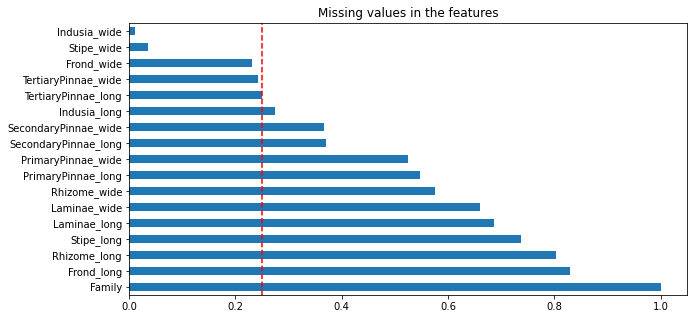

In [84]:
fig, ax = plt.subplots(figsize=(10, 5))
(data.notna().sum()/data.shape[0]).sort_values(ascending=False).plot(kind='barh', figsize=(10, 5), title='Missing values in the features')
ax.axvline(0.25, color='r', linestyle='--')